# Country Economic Conditions for Cargo Carriers

This report is written from the point of view of a data scientist preparing a report to the Head of Analytics for a logistics company. The company needs information on economic and financial conditions is different countries, including data on their international trade, to be aware of any situations that could affect business.

## Data Summary

This dataset is taken from the International Monetary Fund (IMF) data bank. It lists country-level economic and financial statistics from all countries globally. This includes data such as gross domestic product (GDP), inflation, exports and imports, and government borrowing and revenue. The data is given in either US Dollars, or local currency depending on the country and year. Some variables, like inflation and unemployment, are given as percentages.

## Data Exploration

The initial plan for data exploration is to first model the data on country GDP and inflation, then to look further into trade statistics.

In [123]:
#Import required packages
import numpy as np
import pandas as pd
from sklearn import linear_model
from scipy import stats 
import math
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [145]:
#Import IMF World Economic Outlook Data from GitHub
WEO = pd.read_csv('https://raw.githubusercontent.com/jamiemfraser/machine_learning/main/WEOApr2021all.csv')
WEO=pd.DataFrame(WEO)
WEO.head()

,CountryCode,Country,Indicator,Notes,Units,Scale,2000,2001,2002,2003,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,AFG,Afghanistan,Current account balance,Current account is all transactions other than...,U.S. dollars,Billions,NaN,NaN,1.481,1.348,...,4.510,4.754,2.205,0.291,1.353,0.768,1.623,1.434,2.237,2.209
1,AFG,Afghanistan,Current account balance,Current account is all transactions other than...,Percent of GDP,NaN,NaN,NaN,33.908,29.616,...,29.430,26.574,10.864,1.444,6.557,3.796,9.018,7.586,12.158,11.705
2,ALB,Albania,Current account balance,Current account is all transactions other than...,U.S. dollars,Billions,-0.246,-0.248,-0.443,-0.432,...,-1.351,-1.666,-1.257,-1.183,-1.430,-0.981,-0.898,-0.978,-1.024,-1.219
3,ALB,Albania,Current account balance,Current account is all transactions other than...,Percent of GDP,NaN,-7.070,-6.315,-10.179,-7.695,...,-11.321,-12.917,-10.202,-9.253,-10.797,-8.609,-7.572,-7.492,-6.758,-7.979
4,DZA,Algeria,Current account balance,Current account is all transactions other than...,U.S. dollars,Billions,9.142,7.060,4.359,8.808,...,12.157,19.802,12.290,0.835,-9.436,-27.290,-26.473,-22.081,-16.706,-17.150


In [146]:
# Print basic details of the dataset
print(WEO.shape[0])
print(WEO.columns.tolist())
print(WEO.dtypes)

#Shows that all numeric columns are type float, and string columns are type object

4289
['CountryCode', 'Country', 'Indicator', 'Notes', 'Units', 'Scale', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
CountryCode     object
Country         object
Indicator       object
Notes           object
Units           object
Scale           object
2000           float64
2001           float64
2002           float64
2003           float64
2004           float64
2005           float64
2006           float64
2007           float64
2008           float64
2009           float64
2010           float64
2011           float64
2012           float64
2013           float64
2014           float64
2015           float64
2016           float64
2017           float64
2018           float64
2019           float64
dtype: object


### Data Cleaning and Feature Engineering

In [147]:
#We are only interested in the most recent year for which data is available, 2019
WEO=WEO.drop(['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'], axis = 1)

#Reshape the data so each country is one observation
WEO=WEO.pivot_table(index=["Country"], columns='Indicator', values='2019').reset_index()

In [148]:
WEO.columns = ['Country', 'Current_account', 'Employment', 'Net_borrowing', 'Government_revenue', 'Government_expenditure', 'GDP_percap_constant', 'GDP_percap_current', 'GDP_constant', 'Inflation', 'Investment', 'Unemployment', 'Volume_exports', 'Volume_imports']
WEO.head()

,Country,Current_account,Employment,Net_borrowing,Government_revenue,Government_expenditure,GDP_percap_constant,GDP_percap_current,GDP_constant,Inflation,Investment,Unemployment,Volume_exports,Volume_imports
0,Afghanistan,6.9570,NaN,-8.3040,211.4320,219.7360,21715.205,16256.231333,661.9060,58.2830,18.192,NaN,-5.116,-7.862
1,Albania,-4.5990,NaN,-17.4040,243.8695,261.2740,153232.215,201578.086667,420.8445,54.1625,22.828,11.500,1.822,5.014
2,Algeria,-13.5875,NaN,-572.2775,3309.3710,3881.6490,92284.190,7917.200000,3759.9650,104.0760,45.991,11.383,-2.954,-9.573
3,Angola,5.4475,NaN,119.9745,3275.0680,3155.0925,29173.705,365120.193333,772.4600,184.8715,19.638,NaN,0.231,-11.231
4,Antigua and Barbuda,-3.4485,NaN,-2.1125,9.8860,11.9990,29550.240,28730.346667,3.4850,51.2355,32.523,NaN,14.152,2.140


In [149]:
#Describe the dataset
WEO.dropna(inplace=True)
WEO.describe()

,Current_account,Employment,Net_borrowing,Government_revenue,Government_expenditure,GDP_percap_constant,GDP_percap_current,GDP_constant,Inflation,Investment,Unemployment,Volume_exports,Volume_imports
count,36.000000,36.000000,36.000000,36.000000,36.000000,3.600000e+01,3.600000e+01,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,5.634403,14.328167,-163.768222,9198.641139,9362.409361,7.520144e+05,5.392543e+05,34515.076236,58.126000,23.094944,5.354972,2.439083,2.553111
std,53.072653,28.390442,1587.772356,39568.659012,39595.648254,3.026894e+06,2.098897e+06,159393.444025,14.076329,5.195291,3.107695,3.341568,5.984891
min,-241.233000,0.195000,-8716.552500,21.131000,20.850500,2.256274e+04,2.188668e+04,9.014500,50.282500,12.689000,2.001000,-5.550000,-9.311000
25%,-1.083875,2.414750,-15.859625,56.504000,52.696125,3.484550e+04,3.467853e+04,100.417500,51.978000,20.691500,3.716750,0.710000,0.312250
50%,3.941250,4.152000,0.163500,231.269250,235.244250,4.983260e+04,5.211688e+04,488.199500,54.004500,22.627000,4.486500,1.976000,2.201500
75%,17.085500,14.393500,5.931375,660.256000,687.677875,1.287175e+05,1.259422e+05,1381.682250,56.408125,24.666500,6.268250,4.035500,3.370000
max,140.586500,157.536000,3577.686500,220585.494000,217007.807500,1.789988e+07,1.239624e+07,924480.219500,128.732500,44.794000,17.325000,10.598000,31.995000


### Key Findings and Insights

In [150]:
#Large differences betweeen the mean and median values could be an indication of outliers that are skewing the data
WEO.agg([np.mean, np.median])

,Current_account,Employment,Net_borrowing,Government_revenue,Government_expenditure,GDP_percap_constant,GDP_percap_current,GDP_constant,Inflation,Investment,Unemployment,Volume_exports,Volume_imports
mean,5.634403,14.328167,-163.768222,9198.641139,9362.409361,752014.410694,539254.329537,34515.076236,58.1260,23.094944,5.354972,2.439083,2.553111
median,3.941250,4.152000,0.163500,231.269250,235.244250,49832.600000,52116.878333,488.199500,54.0045,22.627000,4.486500,1.976000,2.201500


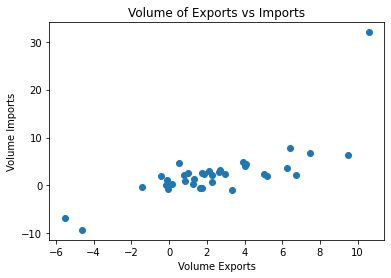

In [151]:
#Create a scatterplot
import matplotlib.pyplot as plt
%matplotlib inline

ax = plt.axes()

ax.scatter(WEO.Volume_exports, WEO.Volume_imports)

# Label the axes
ax.set(xlabel='Volume Exports',
       ylabel='Volume Imports',
       title='Volume of Exports vs Imports');

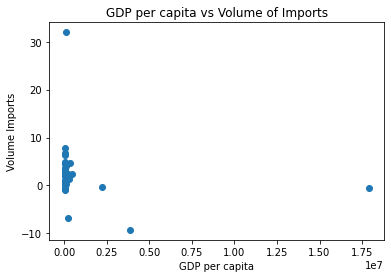

In [156]:
#Create a scatterplot
import matplotlib.pyplot as plt
%matplotlib inline

ax = plt.axes()

ax.scatter(WEO.GDP_percap_constant, WEO.Volume_imports)

# Label the axes
ax.set(xlabel='GDP per capita',
       ylabel='Volume Imports',
       title='GDP per capita vs Volume of Imports');

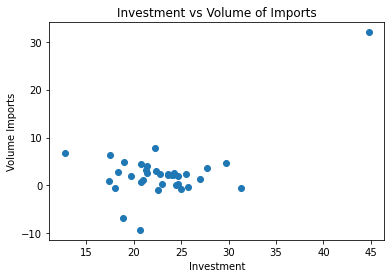

In [157]:
#Create a scatterplot
import matplotlib.pyplot as plt
%matplotlib inline

ax = plt.axes()

ax.scatter(WEO.Investment, WEO.Volume_imports)

# Label the axes
ax.set(xlabel='Investment',
       ylabel='Volume Imports',
       title='Investment vs Volume of Imports');

### Hypotheses

Hypothesis 1: GDP per capita and the level of investment will be significant in determining the volume of goods and services imports

Hypothesis 2: There will be a strong correlation between government revenues and government expenditures

Hypothesis 3: GDP per capita and inflation will be significant in determining the unemployment rate

### Significance Test

I will conduct a formal hypothesis test on Hypothesis #1, which states that GDP per capita and the level of investment will be significant in determining the volume of goods and services imports. I will use a linear regression model because the scatterplots shown above indicate there is likely a linear relationship between both GDP per capita and investment against the volume of imports. I will take a p-value of 0.05 or less to be an indication of significance.

The null hypothesis is that there is no significant relationship between GDP per capita or the level of investment and the volume of goods and services.

The alternative hypothesis is that there is a significant relationship between either GDP per capita or the level of investment and the volume of goods and services.

In [154]:
#Set up a linear regression model for GDP per capita and evaluate
WEO=WEO.reset_index()
X = WEO['GDP_percap_constant']
X=X.values.reshape(-1,1)
y = WEO['Volume_imports']

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:         Volume_imports   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.051
Date:                Wed, 11 Aug 2021   Prob (F-statistic):              0.313
Time:                        06:38:02   Log-Likelihood:                -114.44
No. Observations:                  36   AIC:                             232.9
Df Residuals:                      34   BIC:                             236.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8106      1.028      2.734      0.0

In [155]:
#Set up a linear regression model for Investment and evaluate
WEO=WEO.reset_index()
X = WEO['Investment']
X=X.values.reshape(-1,1)
y = WEO['Volume_imports']

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:         Volume_imports   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     16.38
Date:                Wed, 11 Aug 2021   Prob (F-statistic):           0.000282
Time:                        06:38:22   Log-Likelihood:                -107.91
No. Observations:                  36   AIC:                             219.8
Df Residuals:                      34   BIC:                             223.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.6186      3.839     -3.287      0.0

The linear regression analyses show that while GDP per capita is not significant in determining the volume of imports, investment is significant. For GDP per capita, we obtain a p-value of 0.313 which is insignificant. For Investment, we obtain a p-value of 0.000, which is significant.

## Next Steps

Next steps in analysing the data would be to see if there are any other variables that are significant in determining the volume of imports. The data scientist could also try a multiple linear regression to determine if there are variables that together produce a significant effect.

### Data Quality

The quality of this dataset is questionable. The exploratory data analysis showed several outliers that could be skewing the data. Further, there is no defined uniformity for how this data is measured. It is reported on a country-by-country basis, which leaves open the possibility that variation in definitions or methods for measuring these variables could lead to inaccurate comparison between countries.

Further data that I would request is more detailed trade data. Specifically, because this analysis finds that investment is significant in determining the volume of imports, it would be interesting to see which types of goods are more affected by investment. This could inform business decisions for a logistics company by allowing it to predict what type of cargo would need to be moved depending on investment practices in an individual country.